# Lab 07: Airline Tweets Sentiment Analysis

---
author: Yiran Hu
date: April 8, 2024
embed-resources: true
---

## Introduction

In this lab7, our goal is to develop a sentiment classifier for a major US airline. By analyzing tweets, the classifier will automatically categorize them as negative, neutral, or positive. This tool aims to improve customer service by quickly identifying and responding to customer feedback.

We'll use a modified version of the "Twitter US Airline Sentiment" dataset from Kaggle, focusing on tweet text and sentiment. Employing the Naive Bayes model, known for its efficiency in text analysis, we aim to achieve accurate sentiment classification. This approach not only enhances customer service response times but also showcases the practical application of machine learning in real-world scenarios.

## Methods

In [362]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from joblib import dump
from matplotlib import pyplot as plt

### Data

In [363]:
tweets = pd.read_csv("https://cs307.org/lab-07/data/tweets.csv")

The dataset we're using originates from Crowdflower's Data for Everyone library and has been reformatted for the lab. It consists of Twitter data from February 2015, where tweets about major US airlines were classified by sentiment (positive, negative, neutral) and negative tweets further categorized by issues like "late flight" or "rude service". Available in both CSV and SQLite formats, the transformation code is accessible on GitHub.

In [364]:
tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)

# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [365]:
tweets

,sentiment,airline,text
0,negative,United,@united at its worse. Can't figure how to pack...
1,negative,Delta,@JetBlue I did not report the updated info - d...
2,negative,Delta,@JetBlue I'll give u a chance but I don't thin...
3,negative,United,@united Yo yo yo stuck on the tarmac for over ...
4,negative,US Airways,"@USAirways yes, I was rebooked the next day (W..."
...,...,...,...
10975,positive,Southwest,@SouthwestAir replacing @vitaminwater with bee...
10976,negative,American,@AmericanAir at LAX and your service reps just...
10977,negative,Southwest,@SouthwestAir Been on hold for over an hour - ...
10978,negative,United,@united we would...how do I contact you to dis...


In [366]:
# find the 100 most common words in the train tweets
top_100_counter = CountVectorizer(max_features=10000)
X_top_100 = top_100_counter.fit_transform(X_train)
print("Top 100 Words:")
print(top_100_counter.get_feature_names_out())
print("")
X_top_100_dense = X_top_100.todense()  # type: ignore
X_top_100_dense

Top 100 Words:
['00' '000' '000114' ... 'ztrdwv0n4l' 'zurich' 'zv2pt6trk9']



matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Summary Statistics

In [367]:
# Counts and Proportions
airline_count = tweets_train.groupby('airline').agg('count').reset_index()
airline_count['proportion'] = airline_count['text']/airline_count['text'].sum()
airline_count

,airline,sentiment,text,proportion
0,American,1551,1551,0.188342
1,Delta,1239,1239,0.150455
2,Southwest,1347,1347,0.163570
3,US Airways,1664,1664,0.202064
4,United,2166,2166,0.263024
5,Virgin America,268,268,0.032544


In [368]:
# word occurrence in each airline
word_counter = CountVectorizer()
word_counts = word_counter.fit_transform(X_train)
# find "cancelled", "please", "thanks"
for key, value in word_counter.vocabulary_.items():
    if key in ["cancelled", "please", "thanks"]:
        print(f"{key}: {word_counts[:, value].sum()}")  # type: ignore

thanks: 587
please: 325
cancelled: 595


#### Visualization

In [369]:
# groupby 'sentiment' and 'airline'
visual = tweets_train.groupby(
    ['sentiment', 'airline']).agg('count').reset_index()
visual

,sentiment,airline,text
0,negative,American,1106
1,negative,Delta,511
2,negative,Southwest,664
3,negative,US Airways,1269
4,negative,United,1485
5,negative,Virgin America,83
6,neutral,American,275
7,neutral,Delta,410
8,neutral,Southwest,384
9,neutral,US Airways,237


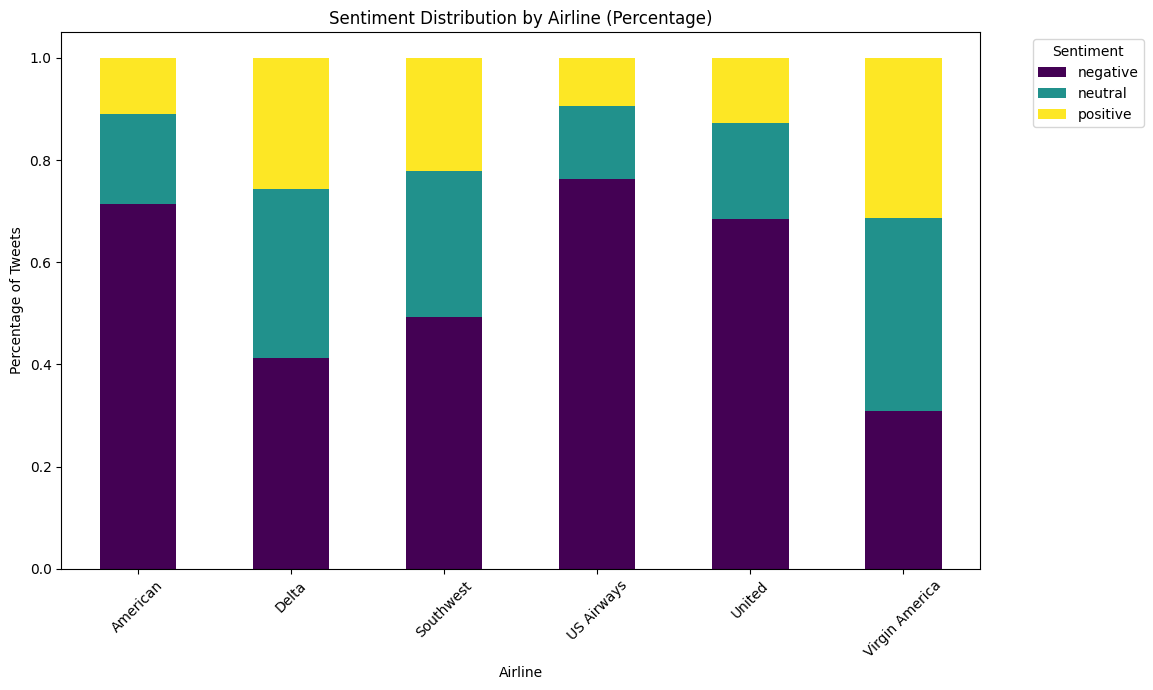

In [370]:
# Convert the counts to percentages for the 100% stacked bar chart
pivot_df = visual.pivot(
    index='airline', columns='sentiment', values='text').fillna(0)
pivot_percentage = pivot_df.divide(pivot_df.sum(axis=1), axis=0)

# Plot a 100% stacked bar chart
pivot_percentage.plot(kind='bar', stacked=True,
                      figsize=(10, 7), colormap='viridis')
plt.title('Sentiment Distribution by Airline (Percentage)')
plt.xlabel('Airline')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The stacked bar chart demonstrates the sentiment proportions for each airline: United, American and US Airways exhibit a notably larger share of negative sentiment in comparison to their positive feedback. In contrast, Virgin America and Delta shows a more balanced distribution with the highest relative share of positive sentiment. 

### Models

In [371]:
pipeline = make_pipeline(
    CountVectorizer(max_features=10000, ngram_range=(1, 3)),
    MultinomialNB(alpha=2.41, fit_prior=False)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('multinomialnb', MultinomialNB(alpha=2.41, fit_prior=False))])

In [372]:
dump(pipeline, "airline-sentiment.joblib")

['airline-sentiment.joblib']

The model I've developed is a text classification pipeline utilizing a CountVectorizer with a maximum of 10,000 features and n-gram ranging from 1 to 3, followed by a Multinomial Naive Bayes classifier with a smoothing parameter of 2.41. 

## Results

In [373]:
predictions = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7941712204007286


The model has been trained on a dataset of airline tweets and is capable of predicting sentiment with an accuracy of approximately 79.42%. The relatively high accuracy suggests that the model is effective in classifying tweets as negative, neutral, or positive.

## Discussion

Given the current accuracy of approximately 79.42%, the decision to implement this model in a real-world scenario warrants caution. While the model performs reasonably well, it falls short of a more desirable accuracy threshold, which could be closer to the high 80s or 90s for greater confidence in a customer service environment. The potential mistakes due to this limitation could involve misclassifying negative tweets as neutral or positive, potentially overlooking critical customer service issues that require immediate attention. Such errors could lead to customer dissatisfaction and damage to the airline's reputation. There's also a risk of wasting resources by responding to falsely identified negative sentiments. To improve the model, further fine-tuning of hyperparameters, incorporating a more sophisticated feature selection, or exploring more advanced models could be considered to enhance its accuracy and reliability for practical use.

### Conclusion

In conclusion, Lab 07 harnessed the power of machine learning with a focus on natural language processing, utilizing the Naive Bayes algorithm to analyze and classify sentiments from airline-related tweets. Leveraging a modified dataset, the constructed model achieved a reasonable accuracy that suggests potential for aiding real-time social media monitoring and customer service tasks. Although the model provides a substantial step towards automating sentiment analysis, its performance, with an accuracy around 79.42%, indicates room for improvement. It is essential to recognize the model’s limitations in capturing the full spectrum of human emotion expressed in text. Therefore, while the Naive Bayes classifier can significantly support customer engagement strategies, it should be employed as an assistive tool rather than a standalone solution, complementing human judgment and decision-making in managing customer relations.